In [35]:
#Computer Vision Project
#Simone Bartoli
#Paolo Caligiana

In [5]:
#Libraries
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

# Import additional library to properply play videos on jupyter notebook
from IPython.display import clear_output

In [7]:
#Utility function to ease the erosion process
def erode(img, k):
    kernel = np.ones((2*k+1,2*k+1),np.uint8)
    img_eroded = cv.erode(img,kernel,iterations = 1)
    return img_eroded

In [9]:
#Return:
# Image with keypoints drawn
# Key_point list
# Descriptor list
def compute_kp(img):
    img_copy = img.copy()
    gray= cv.cvtColor(img_copy,cv.COLOR_BGR2GRAY)
    sift = cv.xfeatures2d.SIFT_create()
    kp = sift.detect(gray,None)
    img_kp=cv.drawKeypoints(gray,kp,img_copy)
    kp,des = sift.compute(gray,kp)   
    return img_kp,kp,des

In [10]:
#Utility function to ease the plotting of images
def plot_image(img, title):
    plt.figure(figsize=(15,15))
    plt.axis('off')
    plt.title(title)
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.show()
    return

In [11]:
#Personal Harris Operator Function
#It returns the coordinates of the corners of the enclosing rectangle
def harris(img):

    gray = cv.cvtColor(img_mask,cv.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    dst = cv.cornerHarris(gray,2,3,0.04)

    #result is dilated for marking the corners, not important
    dst = cv.dilate(dst,None)

    ret, dst = cv.threshold(dst,0.4*dst.max(),255,0)
    dst = np.uint8(dst)

    #find centroids
    ret, labels, stats, centroids = cv.connectedComponentsWithStats(dst)

    #define the criteria to stop and refine the corners
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 0.001)
    corners = cv.cornerSubPix(gray,np.float32(centroids),(5,5),(-1,-1),criteria)

    return corners[1:5]

In [13]:
#Draw the augmented layer onto the given image (image), applying the homography (M)
def draw_augmented_image(image, image2project, white_mask, M):
    image2project = image2project[0:image.shape[0], 0:image.shape[1],:]

    h, w = image.shape[0], image.shape[1]
    h_2, w_2=  image2project.shape[0], image2project.shape[1]

    # Apply the transformation matrix 
    warped = cv.warpPerspective(image2project, M, (w, h))
    # Warp a white mask to understand what are the black pixels
    white_mask = white_mask[0:h_2, 0:w_2,:]
    warp_mask = cv.warpPerspective(white_mask, M, (w, h))
    # Erosion operator in order to get rid of colour artefacts
    warp_mask = erode(warp_mask,1)
    warp_mask = np.equal(warp_mask, np.array([0,0,0]))
    # Restore previous values
    warped[warp_mask] = image[warp_mask]
    
    return warped

In [15]:
#Draw the augmented enclosing rectangle that shows the object detected
def draw_enclosing_rectangle(image,M):
    img_mask = cv.imread('ObjectMask.png') # referenceImageMask
    
    # Get corners' points by Harris operator
    corners = harris(img_mask)
    
    # Get coordinates of corners
    pts = np.float32([corners]).reshape(-1, 1, 2)
    
    # Project corners into frame
    dst = cv.perspectiveTransform(pts, M)  
    
    # Draw the rectangle
    img_rectangle = image.copy()
    img_rectangle = cv.polylines(img_rectangle, [np.int32(dst)], True, 255, 3, cv.LINE_AA) 
    
    return img_rectangle

In [40]:
def frame_to_reference(video_path, img_ref, ref_kp, ref_des):
    
    image2project = cv.imread("AugmentedLayer.png")      # AugmentedImage
    augmented_mask = cv.imread("AugmentedLayerMask.png") # AugmentedImageMask
    
    MIN_MATCHES = 30  
    RATIO = 0.75
    cap = cv.VideoCapture(video_path)
    
    # Getting original video params
    w = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
    h = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv.CAP_PROP_FPS)
    fourcc = cv.VideoWriter_fourcc(*'DIVX')
    out = cv.VideoWriter('Augmented Multiple View.avi', fourcc, fps, (w,  h))
    
    try:        # Try-except statement to manage exceptions
        i = 0
        while(True):
            # Capture frame
            ret, frame = cap.read()
            if not ret or frame is None:
                # Release the Video if ret is false
                cap.release()
                print("Released Video Resource")
                # Break exit the for loops
                break
                       
            frame_kp, kp, des = compute_kp(frame)      # Seek keypoints in the frame 
            bf = cv.BFMatcher()                        # create BFMatcher object
            matches = bf.knnMatch(ref_des,des, k = 2)  # Match descriptors
            
            # Apply ratio test
            good = []
            for m,n in matches:
                if m.distance < RATIO*n.distance:
                    good.append(m)

            print('Number of matches found: {}'.format(len(good)))
            
            if len(good) > MIN_MATCHES:
                img_matches = cv.drawMatches(img_ref,ref_kp,frame,kp,good[:MIN_MATCHES],None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
                plot_image(img_matches, 'Frame {}'.format(i+1))
                
                src_pts = np.float32([ref_kp[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)  # Source points
                dst_pts = np.float32([kp[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)      # Destination points
                
                M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)             # Compute Homography
            
                warped = draw_augmented_image(frame, image2project, augmented_mask, M)    # Apply augmented layer
                plot_image(warped,'Frame {}'.format(i+1))                                 # Plot augmented image
                out.write(warped)                                                         # Write the frame in the new output video
                
                img_rectangle = draw_enclosing_rectangle(frame, M)
                plot_image(img_rectangle, 'Frame {} - Enclosing rectangle'.format(i+1))
            i = i + 1
            clear_output(wait=True) # Clear cell output when new frame is available
    except KeyboardInterrupt:
        # If we press stop (jupyter GUI) release the video
        cap.release()
        print("Released Video Resource")

In [38]:
def update_reference_image(img, img_mask, M):
    
    h, w = img.shape[0], img.shape[1]
    
    warp_img_mask = cv.warpPerspective(img_mask, M, (w, h))
    query_img = 0 * np.ones(shape=img.shape, dtype=np.uint8)
    #Erosion of the mask in order to filter out parts of the image that do not belong to the book
    img_mask = erode(img_mask,2)
    warp_mask = np.equal(warp_img_mask, np.array([255,255,255]))

    query_img[warp_mask] = img[warp_mask]
    img_ref_kp, ref_kp, ref_des = compute_kp(query_img)
    
    return query_img, ref_kp, ref_des

In [43]:
def frame_to_frame(video_path, img_ref, ref_kp, ref_des, img_mask):
    
    image2project = cv.imread("AugmentedLayer.png")      # AugmentedImage
    augmented_mask = cv.imread("AugmentedLayerMask.png") # AugmentedImageMask
    
    MIN_MATCHES = 30    
    RATIO = 0.75
    cap = cv.VideoCapture(video_path)
    
    # Getting original video params
    w = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
    h = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv.CAP_PROP_FPS)
    fourcc = cv.VideoWriter_fourcc(*'DIVX')
    out = cv.VideoWriter('Augmented Multiple View.avi', fourcc, fps, (w,  h))
    
    current_M = 1   # It updates all the homographies applied
    
    try:            # Try-except statement to manage exceptions
        i = 0
        while(True):
            # Capture frame
            ret, frame = cap.read()
            if not ret or frame is None:
                # Release the Video if ret is false
                cap.release()
                print("Released Video Resource")
                # Break exit the for loops
                break
                       
            frame_kp, kp, des = compute_kp(frame)      # Seek keypoints in the frame 
            bf = cv.BFMatcher()                        # create BFMatcher object
            matches = bf.knnMatch(ref_des,des, k = 2)  # Match descriptors
            
            # Apply ratio test
            good = []
            for m,n in matches:
                if m.distance < RATIO*n.distance:
                    good.append(m)

            print('Number of matches found: {}'.format(len(good)))
            
            if len(good) > MIN_MATCHES:
                img_matches = cv.drawMatches(img_ref,ref_kp,frame,kp,good[:MIN_MATCHES],None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
                plot_image(img_matches, 'Frame {}'.format(i+1))
                
                src_pts = np.float32([ref_kp[m.queryIdx].pt for m in good]).reshape(-1, 1, 2) # Source points
                dst_pts = np.float32([kp[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)     # Destination points
                
                M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)              # Compute Homography

                current_M = M.dot(current_M)                                                   # Update the homograpy matrix
                warped = draw_augmented_image(frame, image2project, augmented_mask, current_M) # Apply augmented layer
                plot_image(warped,'Frame {}'.format(i+1))                                      # Plot augmented image
                out.write(warped)                                                              # Write the frame in the new output video
                
                img_rectangle = draw_enclosing_rectangle(frame, current_M)
                plot_image(img_rectangle, 'Frame {} - Enclosing rectangle'.format(i+1))
                
                #Update the reference data, using the current frame instead of the reference frame
                img_ref, ref_kp, ref_des = update_reference_image(frame, img_mask, current_M)
                
            # Clear cell output when new frame is available
            clear_output(wait=True)
            i = i + 1
            
    except KeyboardInterrupt:
        # If we press stop (jupyter GUI) release the video
        cap.release()
        print("Released Video Resource")

In [23]:
#Common setup between F2F and F2R solutions 

img = cv.imread('ReferenceFrame.png')  # referenceImage
img_mask = cv.imread('ObjectMask.png') # referenceImageMask

#Definition of a black image
query_img = 0 * np.ones(shape=img.shape, dtype=np.uint8)

#Erosion of the mask in order to filter out parts of the image that do not belong to the book
img_mask = erode(img_mask,2)
warp_mask = np.equal(img_mask, np.array([255,255,255]))

#Definition of the query image
query_img[warp_mask] = img[warp_mask]
#Computation of the SIFT descriptors
img_ref_kp, ref_kp, ref_des = compute_kp(query_img)

In [41]:
#Frame to reference
frame_to_reference('Multiple View.avi', query_img, ref_kp, ref_des)

Released Video Resource


Number of matches found: 316


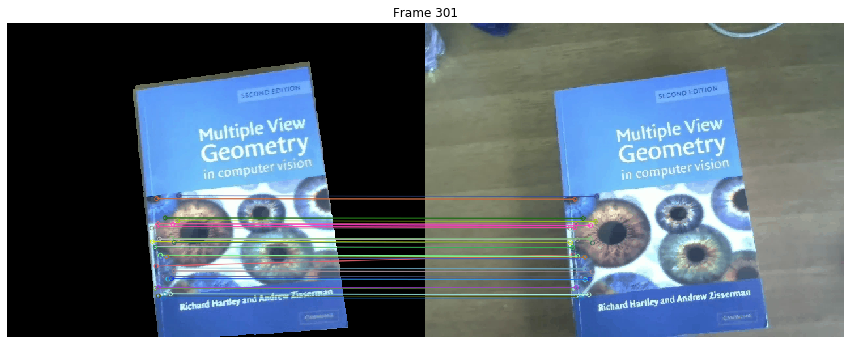

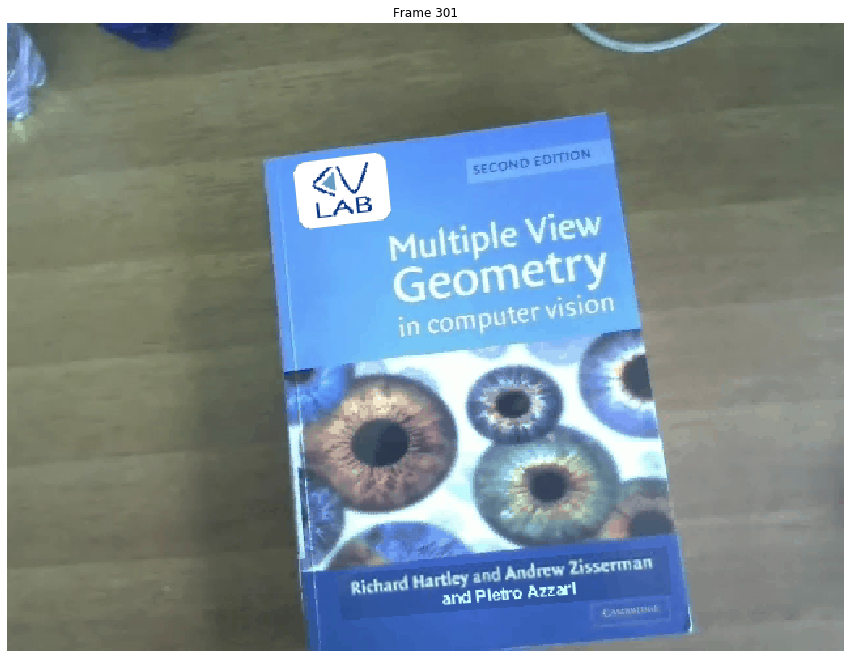

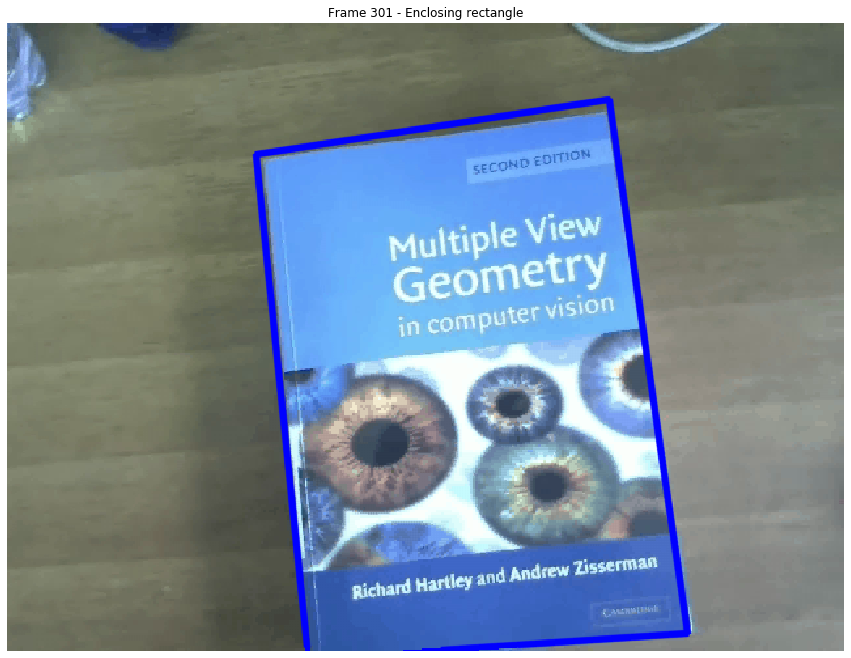

In [24]:
#Frame to frame
frame_to_frame('Multiple View.avi', query_img, ref_kp, ref_des, img_mask)